In [51]:
import os
import pickle
import argparse
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.models import load_model
from PIL import Image
import imgaug as ia
import imgaug.augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
trainpth = "C:/Users/bandung/Downloads/Tugas Akhir/dataset1/train"
valpth ="C:/Users/bandung/Downloads/Tugas Akhir/dataset1/val"
testpth ="C:/Users/bandung/Downloads/Tugas Akhir/dataset1/test"
fullpth= "C:/Users/bandung/Downloads/Tugas Akhir/dataset/test"
TRAINING_DIR = os.path.join(trainpth)
VALIDATION_DIR = os.path.join(valpth)
TESTING_DIR = os.path.join(testpth)
FULL_DIR = os.path.join(fullpth)

In [30]:
#Hyperparam
BATCH_SIZE = 64
IMG_SIZE = (227, 227)
initial_epochs = 10
base_learning_rate = 0.001

In [31]:
train_dataset = tf.keras.utils.image_dataset_from_directory(TRAINING_DIR,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIR,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(TESTING_DIR,
                                                           shuffle=True,
                                                           labels='inferred',
                                                           label_mode='categorical',
                                                           image_size=IMG_SIZE)
full_dataset = tf.keras.utils.image_dataset_from_directory(FULL_DIR,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

Found 8443 files belonging to 8 classes.
Found 2410 files belonging to 8 classes.
Found 1213 files belonging to 8 classes.
Found 12066 files belonging to 8 classes.


In [20]:
class_names = train_dataset.class_names
class_names = [name[:-3] for name in class_names]
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy']

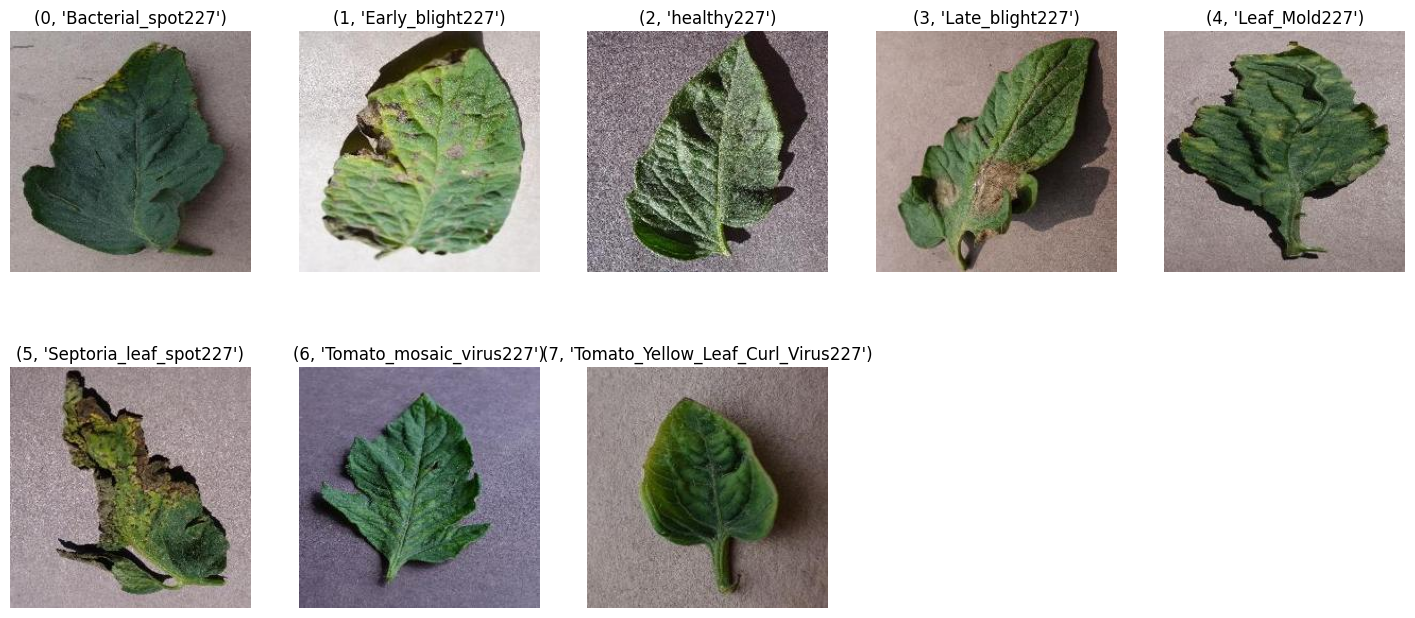

In [23]:
classes = os.listdir(trainpth)

plt.figure(figsize=(18,8))

for i in enumerate(classes):
    pic = os.listdir('C:/Users/bandung/Downloads/Tugas Akhir/dataset1/train/'+i[1])[0]
    image = Image.open('C:/Users/bandung/Downloads/Tugas Akhir/dataset1/train/'+i[1]+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2, 5, i[0]+1)
    plt.title(i)
    plt.imshow(image)
    plt.axis("off")
plt.show()

In [35]:
categories = []
train = []
val = []
test = []
total = []
folders2 = os.listdir("C:/Users/bandung/Downloads/Tugas Akhir/dataset/test")
folders = os.listdir('C:/Users/bandung/Downloads/Tugas Akhir/dataset1/train')
for f in folders:
    categories.append(f)
    train.append(len(os.listdir(os.path.join(trainpth, f))))

folders = os.listdir(valpth)
for f in folders:
    val.append(len(os.listdir(os.path.join(valpth, f))))

folders = os.listdir(testpth)
for f in folders:
    test.append(len(os.listdir(os.path.join(testpth, f))))

folders = os.listdir(testpth)
for f in folders2:
    total.append(len(os.listdir(os.path.join(fullpth, f))))

data_count = pd.DataFrame({'categories': categories,
                     'train': train,
                     'val': val,
                     'test': test,
                     'total' : total                  
                    })

data_count

categories  train  val  test  total
0                 Bacterial_spot227   1191  340   171   1702
1                   Early_blight227    560  160    80    800
2                        healthy227    890  254   128   1272
3                    Late_blight227   1069  305   154   1528
4                      Leaf_Mold227    533  152    77    762
5             Septoria_leaf_spot227    991  283   143   1417
6            Tomato_mosaic_virus227    209   59    31    299
7  Tomato_Yellow_Leaf_Curl_Virus227   3000  857   429   4286

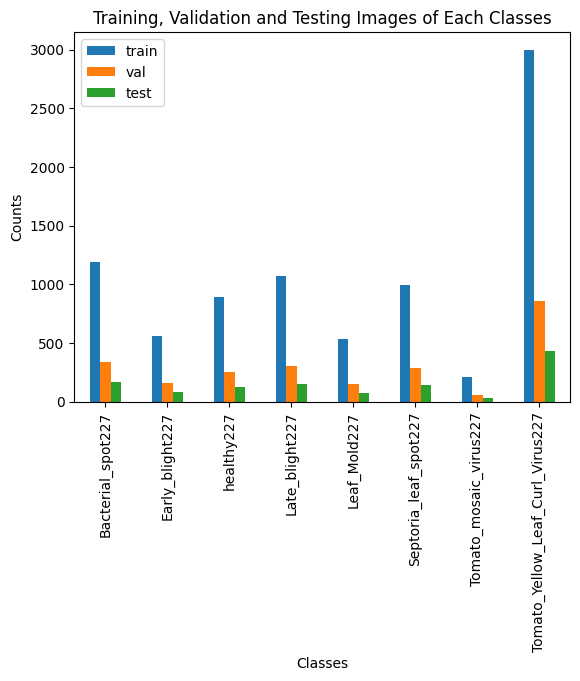

In [17]:
data_count.plot.bar(x='categories', title="Training, Validation and Testing Images of Each Classes")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

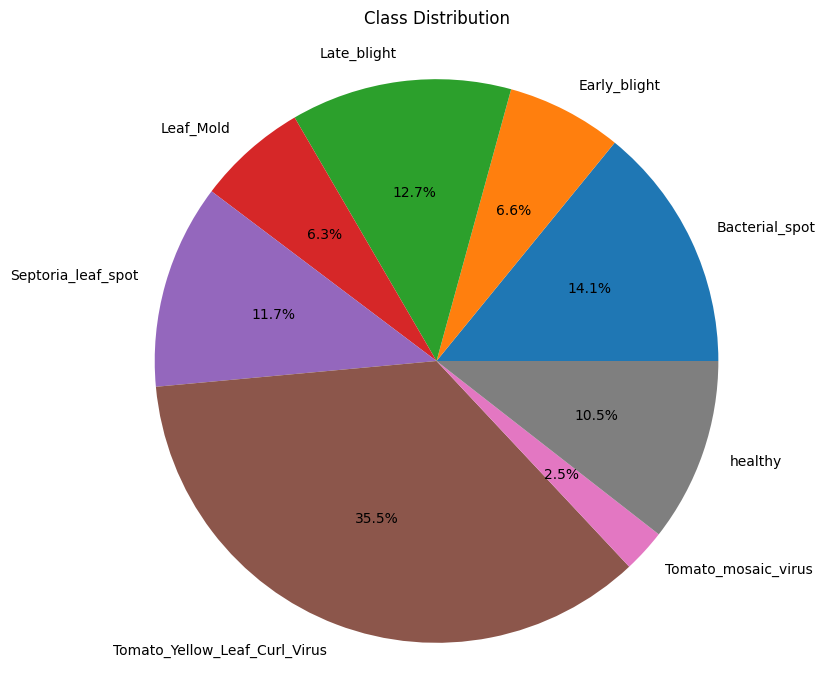

In [33]:
class_counts = [0] * len(class_names)
for images, labels in full_dataset:
    for label in labels:
        class_counts[label] += 1

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Class Distribution\n')
plt.show()

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [24]:
for images, _ in train_dataset.take(1):
    first_image = images[0]

# Print the data type of the first image
print(first_image.dtype)


<dtype: 'float32'>


In [13]:
train_dataset1 = train_dataset.map(lambda x, y: (tf.cast(x, tf.uint8), y))

In [28]:
for images, _ in train_dataset1.take(1):
    first_image = images[0]

# Print the data type of the first image
print(first_image.dtype)


<dtype: 'uint8'>


In [14]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

In [15]:
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

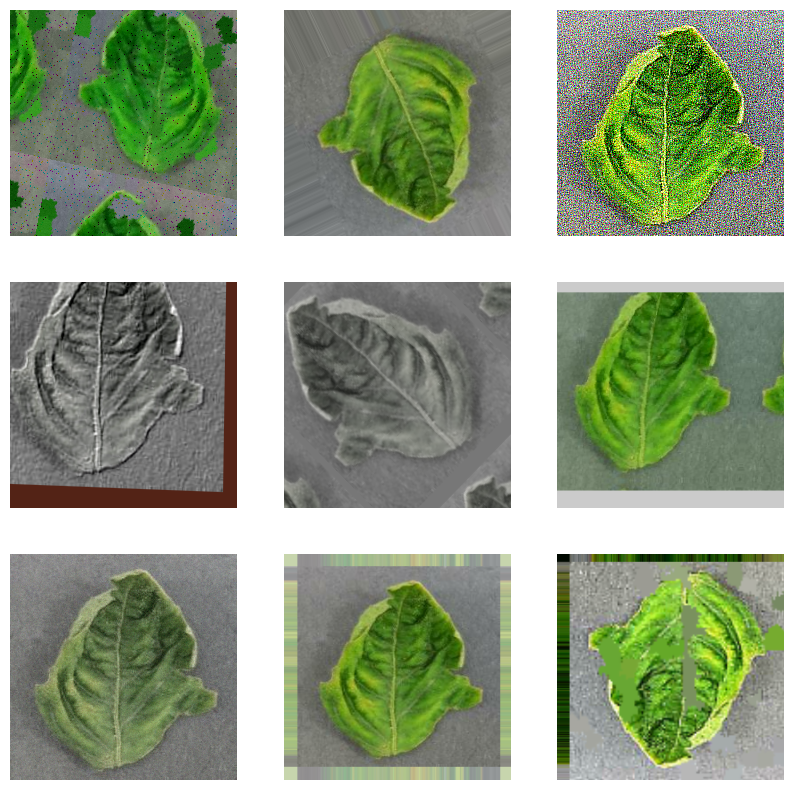

In [16]:
for image, _ in train_dataset1.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = seq.augment_image(first_image.numpy())
        normalized_image = augmented_image / 255.0  # Normalize the image data
        plt.imshow(normalized_image)
        plt.axis('off')
plt.show()

In [17]:
def load_image(filename: str, label: int):
    file = tf.io.read_file(filename)
    img = tf.image.decode_png(file, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    return img, label

In [18]:
def plot_augmentations(augmentation_layer: tf.keras.layers.Layer, dataset):
    augment_name = augmentation_layer.__class__.__name__
    fig, (ax0, *axes) = plt.subplots(ncols=4, figsize=(15, 4))
    for sample_image, _ in dataset.take(1):
        ax0.imshow(sample_image[0].numpy().astype("uint8"))
        ax0.set_title("Original", size=14, pad=10)
        ax0.axis("off")
        for idx, ax in enumerate(axes):
            augmented_image = augmentation_layer(tf.cast(sample_image, tf.float32))
            ax.imshow(augmented_image[0].numpy().astype("uint8"))
            ax.set_title(augment_name.title(), size=14, pad=10)
            ax.axis("off")
    plt.show()

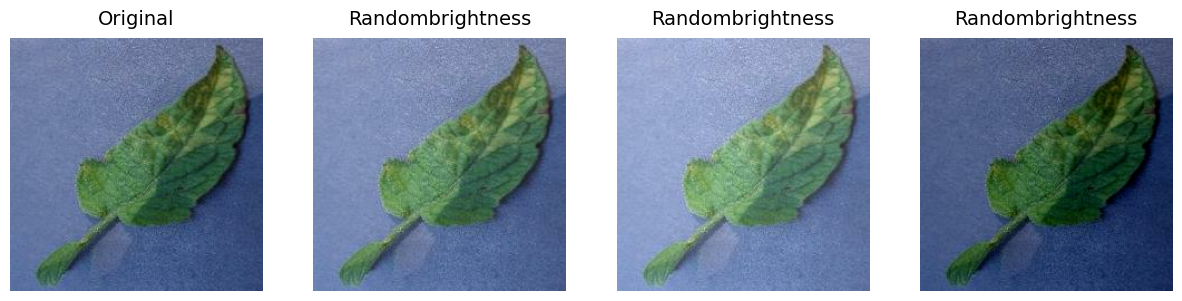

In [82]:
plot_augmentations(layers.RandomBrightness(0.2),train_dataset)

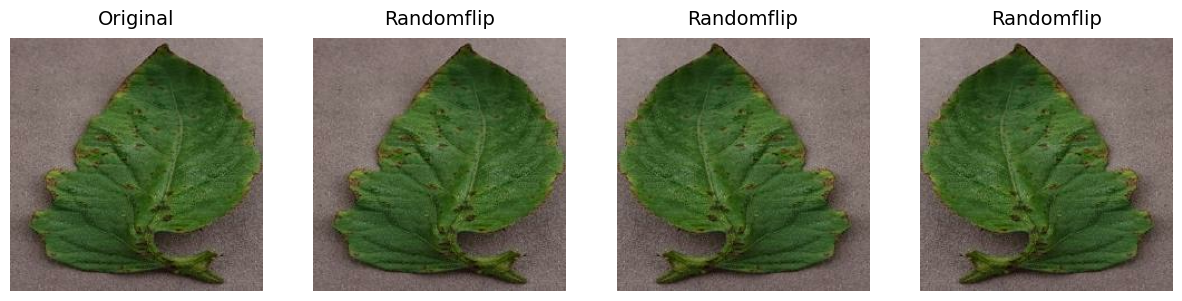

In [84]:
plot_augmentations(layers.RandomFlip('horizontal'),train_dataset)

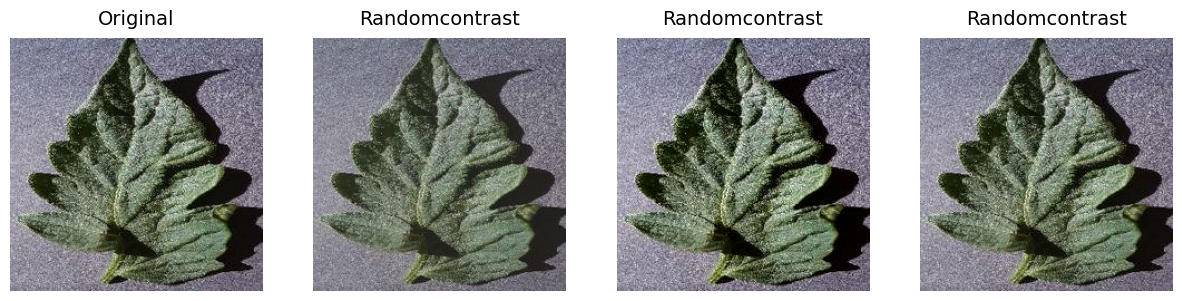

In [88]:
plot_augmentations(layers.RandomContrast(factor=0.3),train_dataset)

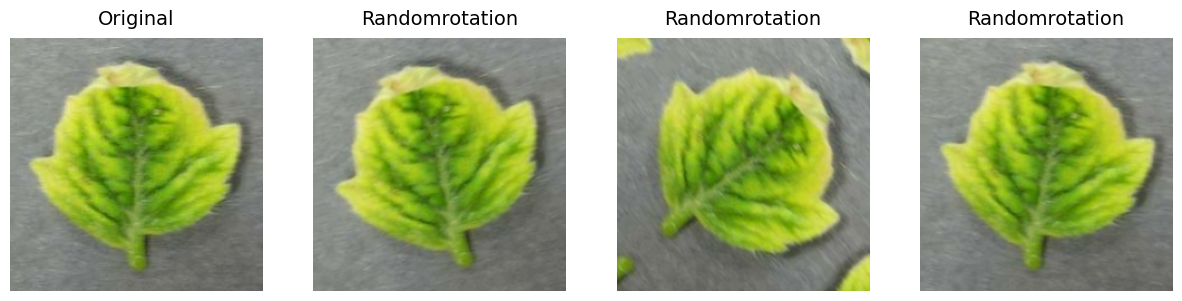

In [81]:
plot_augmentations(layers.RandomRotation(0.4),train_dataset)

In [19]:
def plot_augmentations(augmentation_layer, dataset):
    augment_name = augmentation_layer.__class__.__name__
    fig, (ax0, *axes) = plt.subplots(ncols=4, figsize=(15, 4))
    for sample_image, _ in dataset.take(1):
        ax0.imshow(sample_image[0].numpy().astype("uint8"))
        ax0.set_title("Original", size=14, pad=10)
        ax0.axis("off")
        for idx, ax in enumerate(axes):
            augmented_image = apply_imgaug_augmentation(sample_image, augmentation_layer)
            ax.imshow(augmented_image.astype("uint8"))
            ax.set_title(augment_name.title(), size=14, pad=10)
            ax.axis("off")
    plt.show()

def apply_imgaug_augmentation(image, augmentation_layer):
    image = image[0].numpy().astype("uint8")
    image_aug = augmentation_layer(image=image)
    return image_aug

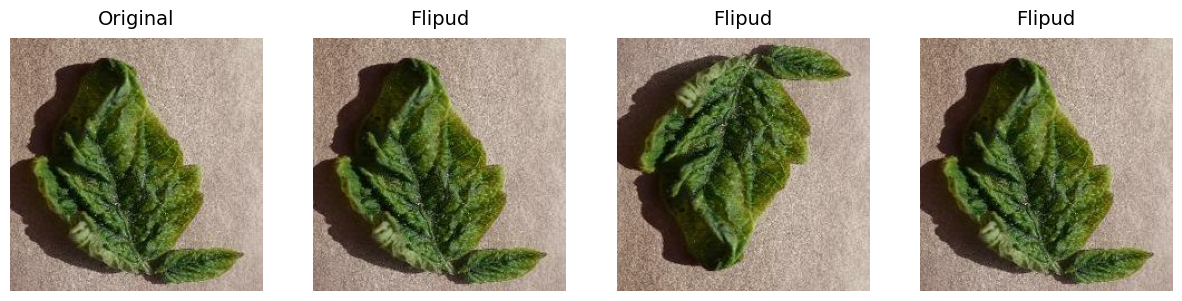

In [76]:
augmentation_layer = iaa.Flipud(0.5)
plot_augmentations(augmentation_layer, train_dataset)

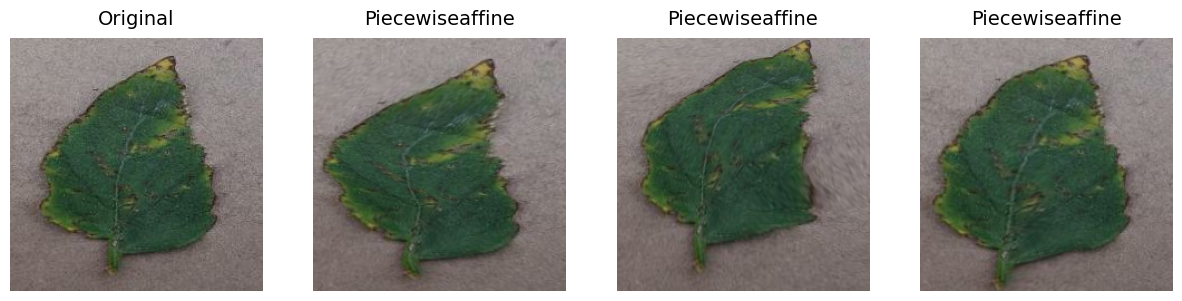

In [70]:
augmentation_layer =  iaa.PiecewiseAffine(scale=(0.1, 0.05))
plot_augmentations(augmentation_layer, train_dataset)

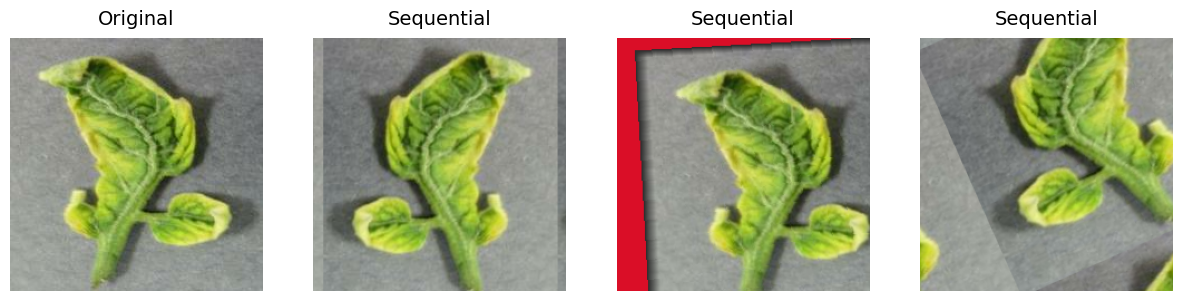

In [24]:
seq = iaa.Sequential([
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        ##iaa.SaltAndPepper(0.05),
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
],random_order=True
)
augmentation_layer = seq
plot_augmentations(augmentation_layer, train_dataset)

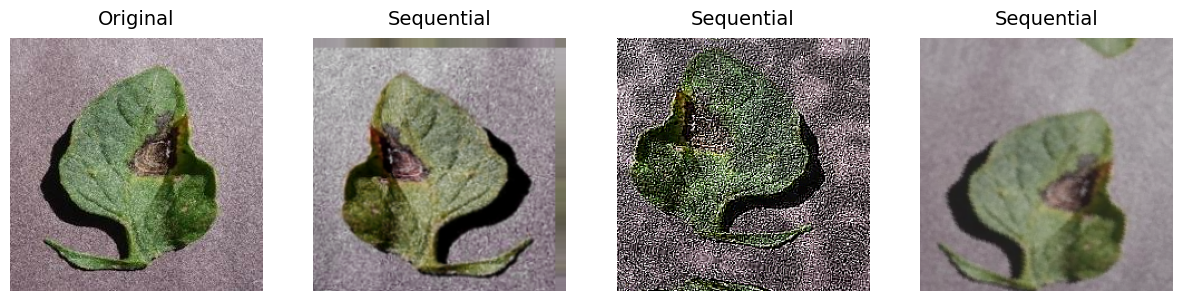

In [174]:
seq = iaa.Sequential([
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        iaa.SomeOf((0, 5),
            [
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)
augmentation_layer = seq
plot_augmentations(augmentation_layer, train_dataset)

In [53]:
# Augmentation parameters
rotation_range = 45  # Rotation angle range (in degrees)
horizontal_flip = True  # Flip images horizontally
vertical_flip = True  # Flip images vertically
contrast_factor = 1.5  # Contrast adjustment factor

# Create an instance of the ImageDataGenerator with the desired augmentation options
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip,
    brightness_range=[0.7, 1.3],  # Contrast adjustment range
)


In [54]:
# Set the paths for your original dataset and augmented dataset
original_dataset_path = 'C:/Users/bandung/Downloads/Tugas Akhir/dataset/sampletrain'
augmented_dataset_path = 'C:/Users/bandung/Downloads/Tugas Akhir/dataset/sampleaug'

In [55]:
# Get the list of class subdirectories in the original dataset
class_directories = [subdir for subdir in os.listdir(original_dataset_path) if os.path.isdir(os.path.join(original_dataset_path, subdir))]
class_directories

['Bacterial_spot', 'Early_blight']

In [56]:
for class_dir in class_directories:
    class_original_path = os.path.join(original_dataset_path, class_dir)
    class_augmented_path = os.path.join(augmented_dataset_path, class_dir)

    # Create the class-specific augmented dataset directory if it doesn't exist
    if not os.path.exists(class_augmented_path):
        os.makedirs(class_augmented_path)

    # Get the list of images in the class-specific original dataset directory
    images_list = os.listdir(class_original_path)

    # Create a generator to iterate over the original images and apply augmentation
    augmented_images = datagen.flow_from_directory(
        original_dataset_path,
        classes=[class_dir],
        save_to_dir=class_augmented_path,
        save_prefix='augmented_',
        batch_size=1,
        shuffle=False,
        class_mode=None,
    )

    # Generate augmented images and save them to the class-specific augmented dataset directory
    num_images = len(images_list)
    for _ in range(num_images):
        image = next(augmented_images)[0].astype('uint8')
        augmented_image_path = os.path.join(class_augmented_path, 'augmented_' + images_list[_])
        Image.fromarray(image).save(augmented_image_path)

Found 3 images belonging to 1 classes.
Found 2 images belonging to 1 classes.


In [47]:
# Augmentation parameters
rotation_range = 45  # Rotation angle range (in degrees)
horizontal_flip = True  # Flip images horizontally
vertical_flip = True  # Flip images vertically
contrast_factor = 1.5  # Contrast adjustment factor
num_augmented_images_per_original = 5  # Number of augmented images to generate per original image

# Create an instance of the imgaug augmenter with the desired augmentation options
augmenter = iaa.Sequential([
    iaa.Rotate((-rotation_range, rotation_range)),
    iaa.Fliplr(horizontal_flip),
    iaa.Flipud(vertical_flip),
    iaa.LinearContrast(contrast_factor),
])


In [48]:
# Set the paths for your original dataset and augmented dataset
original_dataset_path = 'C:/Users/bandung/Downloads/Tugas Akhir/dataset1/train'
augmented_dataset_path = 'C:/Users/bandung/Downloads/Tugas Akhir/dataset/auglanjutan'

# Get the list of class subdirectories in the original dataset
class_directories = [subdir for subdir in os.listdir(original_dataset_path) if os.path.isdir(os.path.join(original_dataset_path, subdir))]
class_directories

['Bacterial_spot227',
 'Early_blight227',
 'healthy227',
 'Late_blight227',
 'Leaf_Mold227',
 'Septoria_leaf_spot227',
 'Tomato_mosaic_virus227',
 'Tomato_Yellow_Leaf_Curl_Virus227']

In [49]:
# Generate augmented images for each class
for class_dir in class_directories:
    class_original_path = os.path.join(original_dataset_path, class_dir)
    class_augmented_path = os.path.join(augmented_dataset_path, class_dir)

    # Create the class-specific augmented dataset directory if it doesn't exist
    if not os.path.exists(class_augmented_path):
        os.makedirs(class_augmented_path)

    # Get the list of images in the class-specific original dataset directory
    images_list = os.listdir(class_original_path)

    # Iterate over the original images and apply augmentation
    for image_name in images_list:
        original_image_path = os.path.join(class_original_path, image_name)
        original_image = Image.open(original_image_path)
        original_image_np = np.array(original_image)

        # Generate multiple augmented images for each original image
        for i in range(num_augmented_images_per_original):
            # Apply augmentation
            augmented_image_np = augmenter(image=original_image_np)

            # Save the augmented image to the class-specific augmented dataset directory
            augmented_image_name = f'augmented_{i}_{image_name}'
            augmented_image_path = os.path.join(class_augmented_path, augmented_image_name)
            Image.fromarray(augmented_image_np).save(augmented_image_path)

copy OG image to the augmented dataset as variation

In [57]:
original_dataset_path = 'C:/Users/bandung/Downloads/Tugas Akhir/dataset1/train'
augmented_dataset_path = 'C:/Users/bandung/Downloads/Tugas Akhir/dataset/augdasar'

# Get the list of class subdirectories in the original dataset
class_directories = [subdir for subdir in os.listdir(original_dataset_path) if os.path.isdir(os.path.join(original_dataset_path, subdir))]

# Copy original images to the augmented dataset directory
for class_dir in class_directories:
    class_original_path = os.path.join(original_dataset_path, class_dir)
    class_augmented_path = os.path.join(augmented_dataset_path, class_dir)

    # Create the class-specific augmented dataset directory if it doesn't exist
    if not os.path.exists(class_augmented_path):
        os.makedirs(class_augmented_path)

    # Get the list of images in the class-specific original dataset directory
    images_list = os.listdir(class_original_path)

    # Copy original images to the class-specific augmented dataset directory
    for image_file in images_list:
        original_image_path = os.path.join(class_original_path, image_file)
        augmented_image_path = os.path.join(class_augmented_path, image_file)
        copyfile(original_image_path, augmented_image_path)